In [1]:
!pip install jedi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install bert-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import tensorflow as tf
print(tf.version.VERSION)

2.9.2


In [6]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [7]:
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install -Uqr models/official/requirements.txt

In [9]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub  as hub
# import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert
from bert import tokenization
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from tensorflow.keras.optimizers import Adam
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
import os
import json
def load_data(path):
  train_df = pd.DataFrame()
  text_json = []
  train_path = path
  json_files = [pos_json for pos_json in os.listdir(train_path) if pos_json.endswith('.json')]
  for file in json_files:
      json_d = json.load(open(path+'/'+file))         
      json_dict = json_d
      json_dict =json.dumps(json_dict)
      text_json.append(json.loads(json_dict))
  sentence = ""
  for category in text_json:
      for c in category:
          for categoryData in category[c]: 
              for sentenceText in categoryData['data']:
                  sentence =sentence+sentenceText['text']
              new_row = {'text':sentence, 'category':c} 
              sentence = ""
              train_df = train_df.append(new_row, ignore_index=True)
  return train_df           

In [11]:
train_df=load_data('/content/Train')
valid_df=load_data('/content/Valid')

Streaming output truncated to the last 5000 lines.
<ipython-input-10-b4ca76c1fe8d>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
<ipython-input-10-b4ca76c1fe8d>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
<ipython-input-10-b4ca76c1fe8d>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
<ipython-input-10-b4ca76c1fe8d>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
<ipython-input-10-b4ca76c1fe8d>:21: FutureWar

In [12]:
train_df

,text,category
0,What will the weather be this year in Horsesho...,GetWeather
1,Will it be sunny one hundred thirty five days ...,GetWeather
2,Is it supposed to rain nearby my current locat...,GetWeather
3,"what is the forecast starting on september 1, ...",GetWeather
4,how cold is it in Princeton Junction,GetWeather
...,...,...
13779,rate this textbook 0 stars,RateBook
13780,give 5 out of 6 stars to Coming Home,RateBook
13781,Give Drift: The Unmooring of American Military...,RateBook
13782,give 1 out of 6 points to Revolution World,RateBook


In [13]:
valid_df

,text,category
0,What will the weather be faraway from here?,GetWeather
1,Will there be fog in Tahquamenon Falls State P...,GetWeather
2,Tell me the weather forecast for Gibsland,GetWeather
3,Is there a storm now in NC?,GetWeather
4,What will the weather be in Monument of Lihula...,GetWeather
...,...,...
695,Give Wilco: Learning How to Die a rating of fo...,RateBook
696,Rate this book 3 stars out of 6,RateBook
697,rate the Three Junes one out of 6,RateBook
698,Give four stars to The Broken Window,RateBook


In [14]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_df['category']= label_encoder.fit_transform(train_df['category'])
train_df['category'].unique()
train_df

,text,category
0,What will the weather be this year in Horsesho...,2
1,Will it be sunny one hundred thirty five days ...,2
2,Is it supposed to rain nearby my current locat...,2
3,"what is the forecast starting on september 1, ...",2
4,how cold is it in Princeton Junction,2
...,...,...
13779,rate this textbook 0 stars,4
13780,give 5 out of 6 stars to Coming Home,4
13781,Give Drift: The Unmooring of American Military...,4
13782,give 1 out of 6 points to Revolution World,4


In [15]:
label_encoder = preprocessing.LabelEncoder()
valid_df['category']= label_encoder.fit_transform(valid_df['category'])
valid_df['category'].unique()
valid_df

,text,category
0,What will the weather be faraway from here?,2
1,Will there be fog in Tahquamenon Falls State P...,2
2,Tell me the weather forecast for Gibsland,2
3,Is there a storm now in NC?,2
4,What will the weather be in Monument of Lihula...,2
...,...,...
695,Give Wilco: Learning How to Die a rating of fo...,4
696,Rate this book 3 stars out of 6,4
697,rate the Three Junes one out of 6,4
698,Give four stars to The Broken Window,4


In [16]:
traindf , testdf  = train_test_split(train_df,test_size=0.2, random_state=42)

In [17]:
traindf.shape

(11027, 2)

In [18]:
testdf.shape

(2757, 2)

In [19]:
traindf

,text,category
427,What will the weather be here on dec. 25th?,2
11091,Add the tune to my House Afterwork playlist.,0
4176,I need to book the Fashion Cafe for meal in La...,1
2900,Recite the movie schedule.,6
4339,Book a restaurant for august fourth not far fr...,1
...,...,...
5191,book a spot for 1 at a bakery with crab cake n...,1
13418,give one to this novel,4
5390,Book the Last Exit on Brooklyn 5 hours from no...,1
860,what is the freezing forecast for British Virg...,2


In [20]:
with tf.device('/cpu:0'):
  train_data=tf.data.Dataset.from_tensor_slices((traindf['text'].values,traindf['category'].values))
  valid_data=tf.data.Dataset.from_tensor_slices((valid_df['text'].values,valid_df['category'].values))
  for text , label in train_data.take(3):
    print(text)
    print(label)

tf.Tensor(b'What will the weather be here on dec. 25th?', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'Add the tune to my House Afterwork playlist.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I need to book the Fashion Cafe for meal in Lavina', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [21]:
label_list=[0,1,2,3,4,5,6] #label categories
#maximum length of token input sequence
max_seq_len=64
batch_size=32
bert_layer=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',trainable=True)
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case)

In [22]:
#let's convert raw input to features 1- tokens id 2- input mask 3-input type ids
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_len, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [23]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [24]:
#creating tensor flow input pipeline
with tf.device('/device:GPU:0'):
  #train
  train_data=(train_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  #validation 
  valid_data=(valid_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  #test_data


In [25]:
#train data specification
type(train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [26]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [27]:
def create_model():

  input_word_ids=tf.keras.layers.Input(shape=(max_seq_len,),dtype=tf.int32,name='input_word_ids')
  input_mask=tf.keras.layers.Input(shape=(max_seq_len,),dtype=tf.int32,name='input_mask')
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_len,),dtype=tf.int32,name='input_type_ids')
  pooled_output,sequence_output=bert_layer([input_word_ids,input_mask,input_type_ids])
  drop=tf.keras.layers.Dropout(0.2)(pooled_output)
  output=tf.keras.layers.Dense(7,activation='softmax',name='output')(drop)
  model=tf.keras.Model(
      inputs={
      'input_word_ids':input_word_ids,
      'input_mask':input_mask,
      'input_type_ids':input_type_ids
      },
      outputs=output
  )
  return model

In [28]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)

In [29]:
model=create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 64, 768)]                 'input_mask[0][0]',         

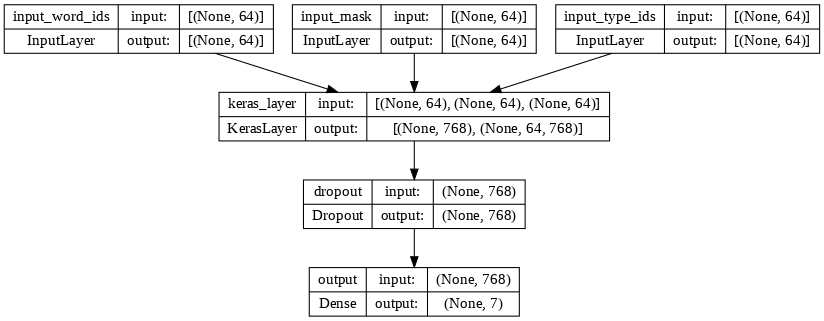

In [30]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [31]:
epochs=20
with tf.device('/device:GPU:0'):
  history=model.fit(train_data,validation_data=valid_data,epochs=epochs,callbacks =[earlystopping])

Epoch 1/20
344/344 [==============================] - 175s 437ms/step - loss: 0.4524 - acc: 0.8471 - val_loss: 0.0642 - val_acc: 0.9807
Epoch 2/20
344/344 [==============================] - 150s 432ms/step - loss: 0.0491 - acc: 0.9870 - val_loss: 0.0653 - val_acc: 0.9851
Epoch 3/20
344/344 [==============================] - 150s 432ms/step - loss: 0.0305 - acc: 0.9917 - val_loss: 0.0566 - val_acc: 0.9881
Epoch 4/20
344/344 [==============================] - 149s 433ms/step - loss: 0.0198 - acc: 0.9946 - val_loss: 0.0539 - val_acc: 0.9866
Epoch 5/20
344/344 [==============================] - 149s 432ms/step - loss: 0.0111 - acc: 0.9972 - val_loss: 0.0724 - val_acc: 0.9881
Epoch 6/20
344/344 [==============================] - 150s 433ms/step - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0540 - val_acc: 0.9881
Epoch 7/20
344/344 [==============================] - 150s 433ms/step - loss: 0.0047 - acc: 0.9986 - val_loss: 0.0755 - val_acc: 0.9866


In [32]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [33]:
# model = tf.keras.models.load_model('saved_model/my_model')

In [53]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
%tensorboard --logdir log

Reusing TensorBoard on port 6006 (pid 1831), started 0:02:01 ago. (Use '!kill 1831' to kill it.)

<IPython.core.display.Javascript object>

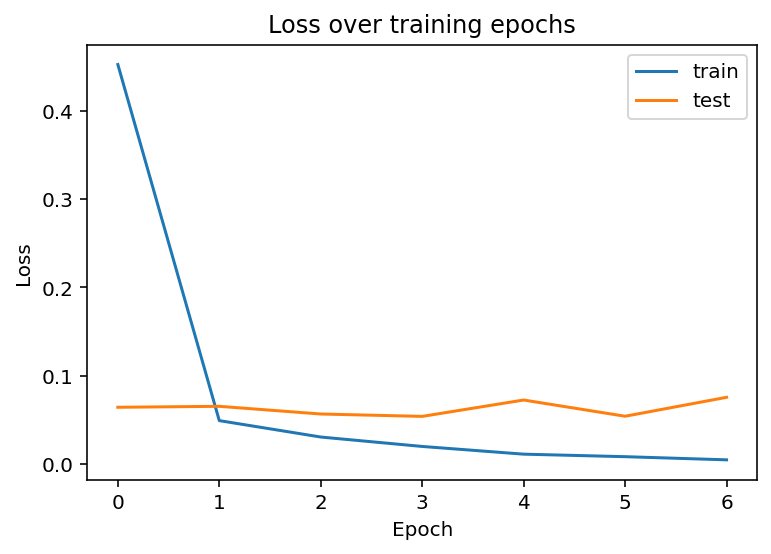

In [36]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [37]:
test_data=tf.data.Dataset.from_tensor_slices((testdf['text'].values,testdf['category'].values))
test_data =(test_data.map(to_feature_map).batch(32))

In [38]:
test=model.evaluate(test_data)

87/87 [==============================] - 13s 142ms/step - loss: 0.0480 - acc: 0.9873


In [39]:
train=model.evaluate(train_data)

344/344 [==============================] - 51s 147ms/step - loss: 0.0081 - acc: 0.9977


In [40]:
validate=model.evaluate(valid_data)

21/21 [==============================] - 3s 143ms/step - loss: 0.0539 - acc: 0.9866


In [41]:
def get_label_name(number):
   Labels=['AddToPlaylist','BookRestaurant','GetWeather','PlayMusic','RateBook','SearchCreativeWork','SearchScreeningEvent']
   return Labels[number]

In [42]:
def prediction_result(sample_example):
  predicted_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
  predicted_data = (predicted_data.map(to_feature_map).batch(1))
  prediction=model.predict(predicted_data)
  result = np.where(prediction[0] == np.amax(prediction[0]))
  return get_label_name(result[0][0])

In [43]:
y=["Will it rain tomorrow"]
x= prediction_result(y)

1/1 [==============================] - 1s 579ms/step


In [44]:
x

'GetWeather'

In [45]:
y_pred = model.predict(test_data).argmax(axis=-1)

87/87 [==============================] - 12s 140ms/step


In [46]:
classes=['AddToPlaylist','BookRestaurant','GetWeather','PlayMusic','RateBook','SearchCreativeWork','SearchScreeningEvent']

In [47]:
y_pred[10:20]

array([1, 3, 0, 1, 6, 6, 4, 5, 2, 2])

In [48]:
test_y=testdf['category'].tolist()

In [49]:
test_y[10:20]

[1, 3, 0, 1, 6, 6, 4, 5, 2, 2]

In [50]:
cm = confusion_matrix(test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

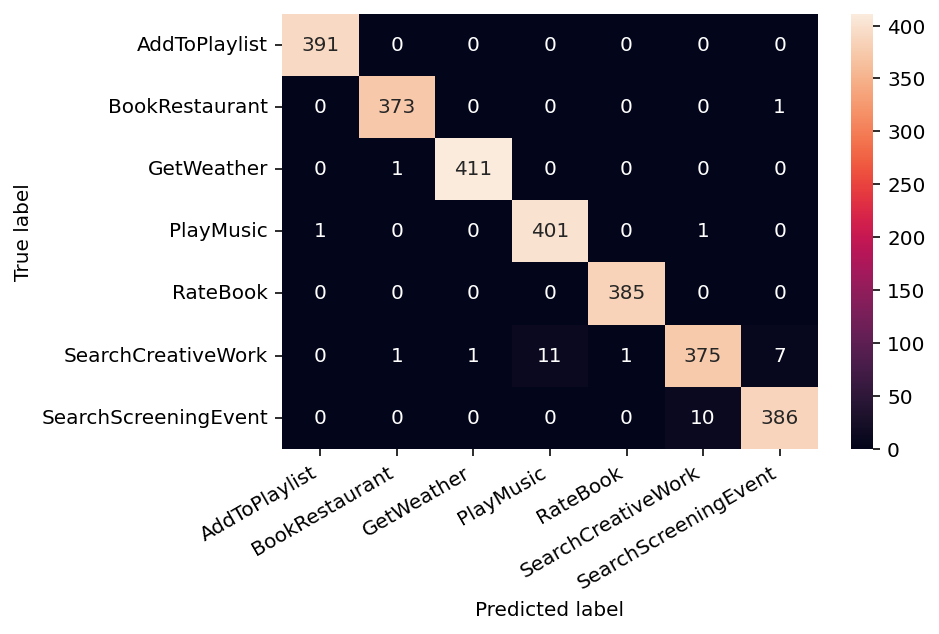

In [51]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [52]:
print(classification_report(test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       391
      BookRestaurant       0.99      1.00      1.00       374
          GetWeather       1.00      1.00      1.00       412
           PlayMusic       0.97      1.00      0.98       403
            RateBook       1.00      1.00      1.00       385
  SearchCreativeWork       0.97      0.95      0.96       396
SearchScreeningEvent       0.98      0.97      0.98       396

            accuracy                           0.99      2757
           macro avg       0.99      0.99      0.99      2757
        weighted avg       0.99      0.99      0.99      2757

